In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from helpers import MultiplePlotMaker, StatAnalysisTools, ModelEvaluation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# TODO: Start with feature engineering and understanding associations.

df = pd.read_csv('clean_data/spotify_songs_clean.csv')
df = df.drop(columns=['uri', 'name', 'artists_names', 'popularity', 'release_date'])

In [4]:
df.head()

duration (ms)  danceability  energy  loudness  speechiness  acousticness  \
0       242485.0         0.574   0.469    -8.209       0.0254         0.534   
1       176440.0         0.551   0.550    -5.339       0.0286         0.777   
2       183956.0         0.464   0.417    -9.345       0.0256         0.136   
3       244360.0         0.445   0.537    -8.532       0.0400         0.695   
4       184791.0         0.573   0.422    -7.621       0.0678         0.551   

   instrumentalness  liveness  valence    tempo  labels  
0          0.000092    0.1280    0.288  132.023       0  
1          0.000000    0.2020    0.342  101.190       0  
2          0.022000    0.0974    0.479   67.528       0  
3          0.000017    0.0944    0.131  122.769       0  
4          0.000013    0.1020    0.693  124.357       0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146066 entries, 0 to 146065
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration (ms)     146066 non-null  float64
 1   danceability      146066 non-null  float64
 2   energy            146066 non-null  float64
 3   loudness          146066 non-null  float64
 4   speechiness       146066 non-null  float64
 5   acousticness      146066 non-null  float64
 6   instrumentalness  146066 non-null  float64
 7   liveness          146066 non-null  float64
 8   valence           146066 non-null  float64
 9   tempo             146066 non-null  float64
 10  labels            146066 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 12.3 MB


### Feature Engineering

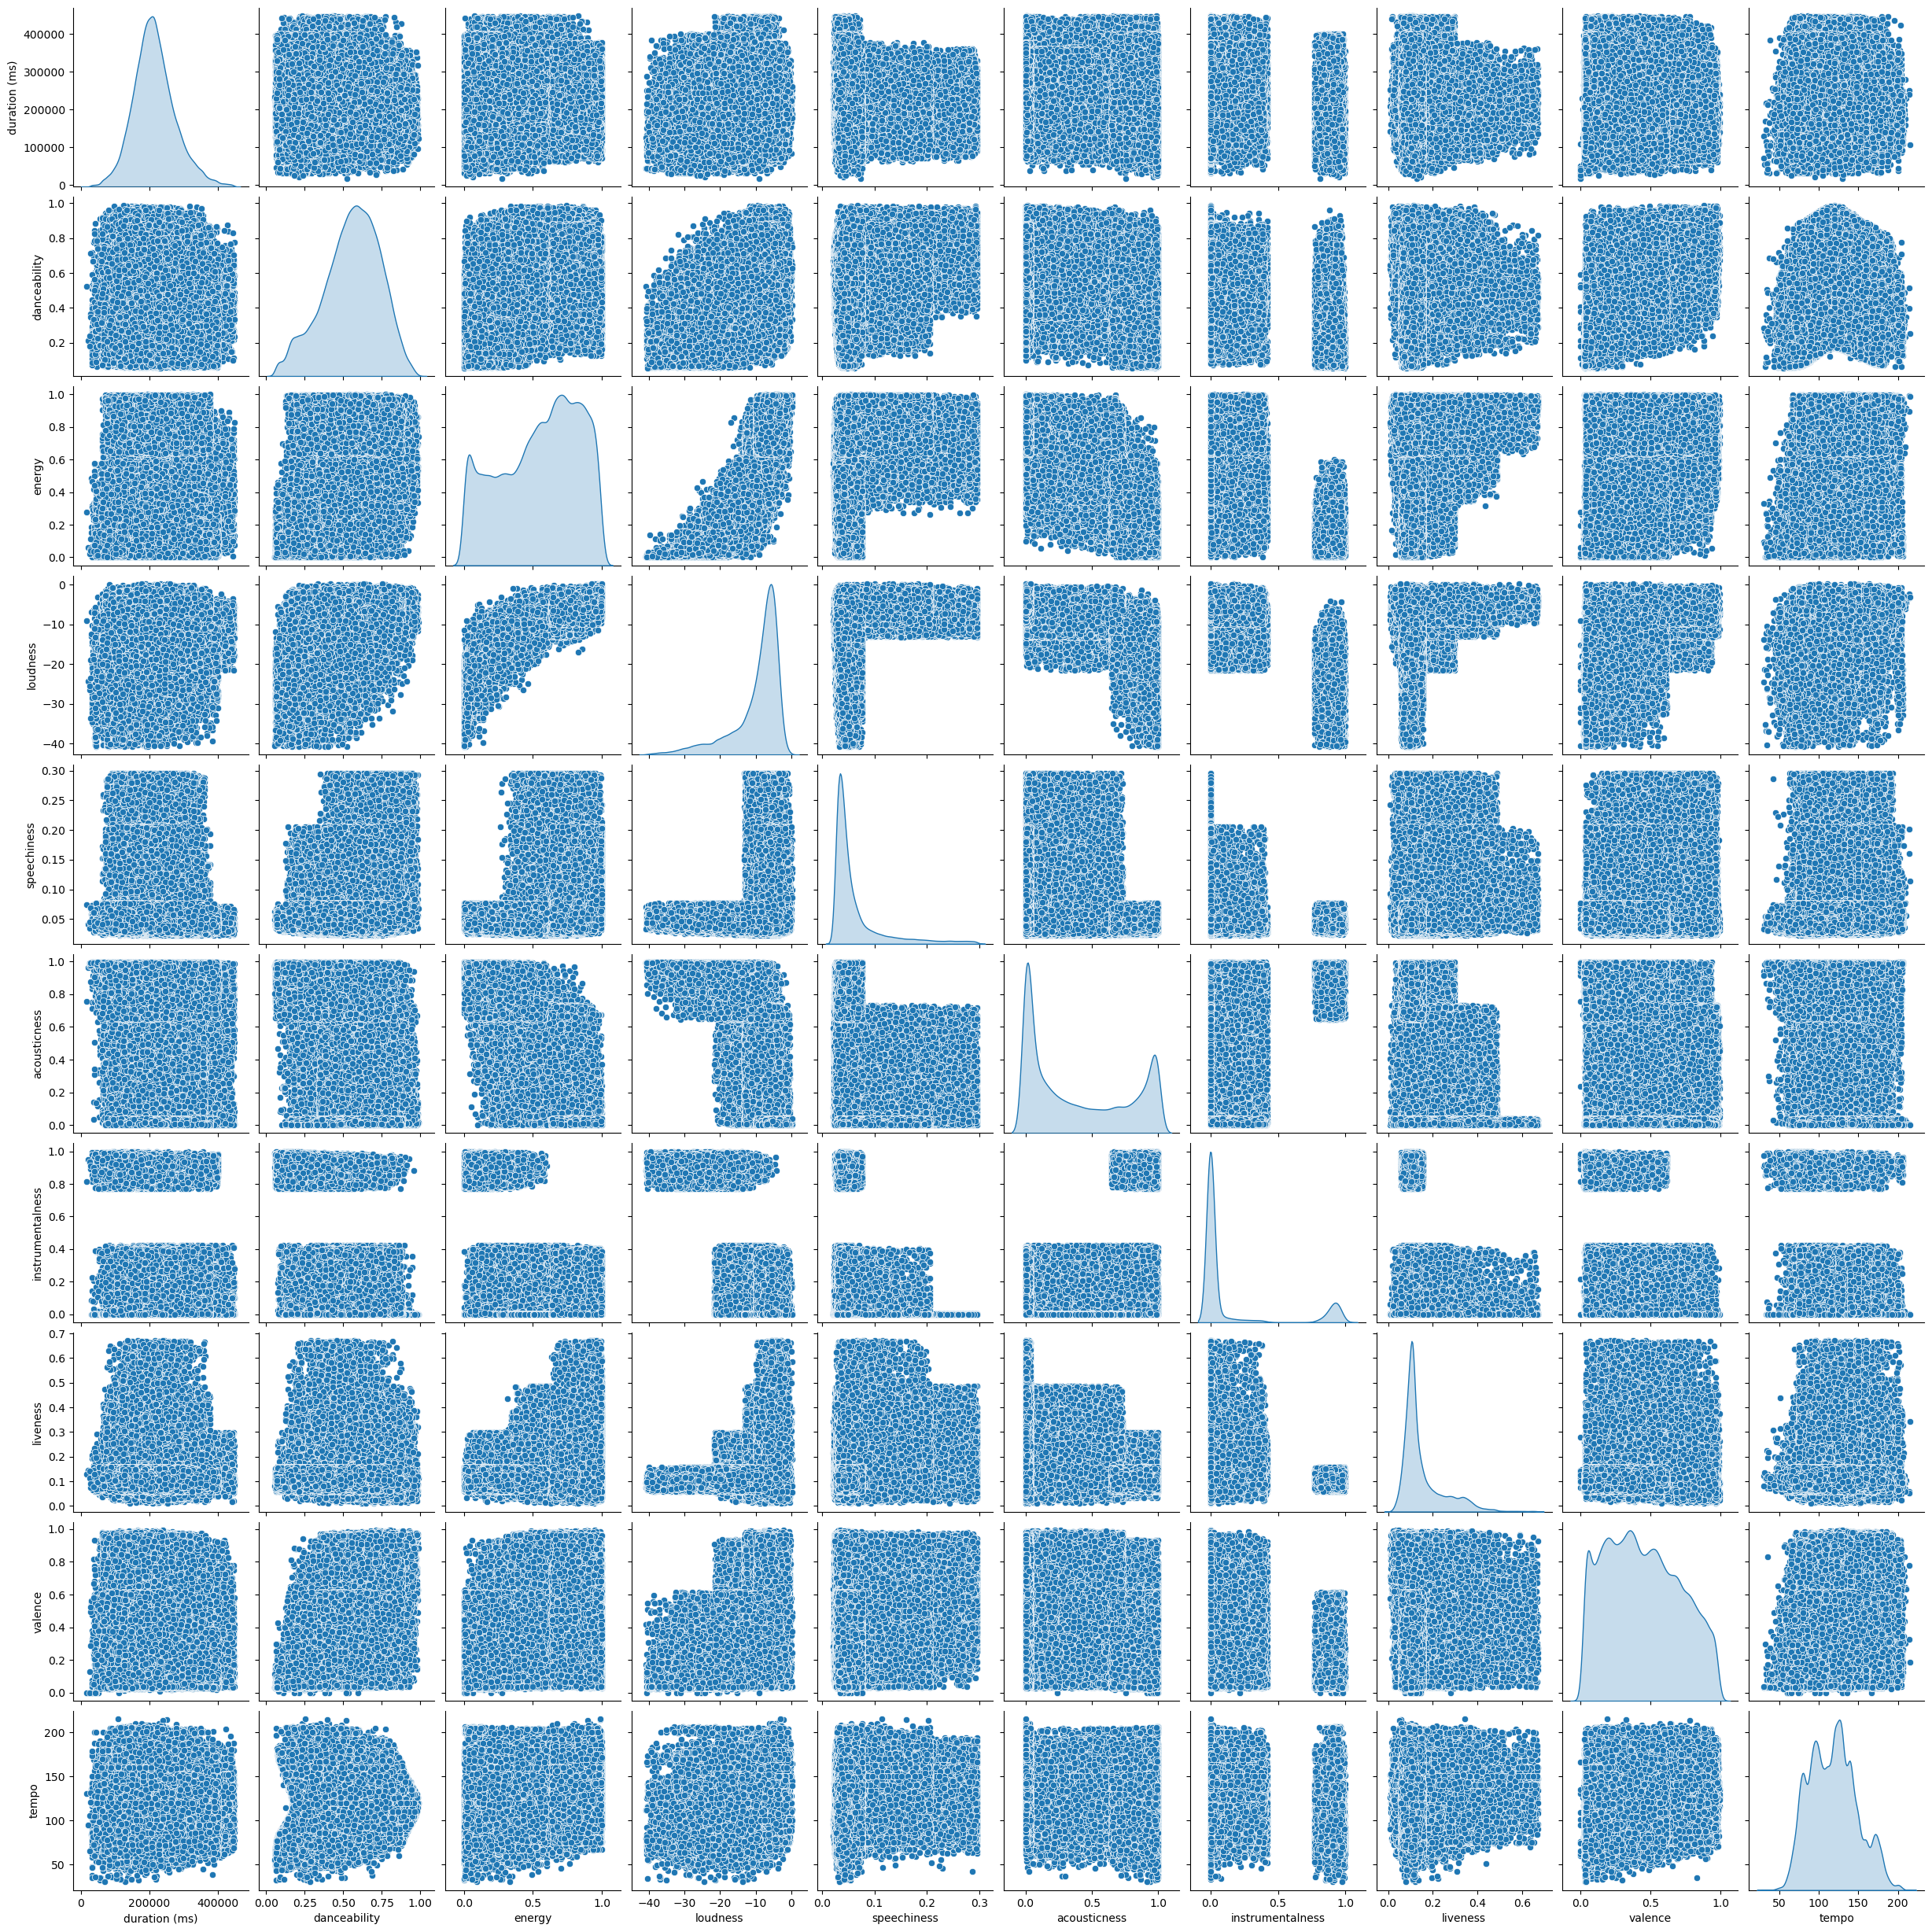

In [6]:
sns.pairplot(df.drop(columns='labels'), diag_kind='kde')
plt.show()

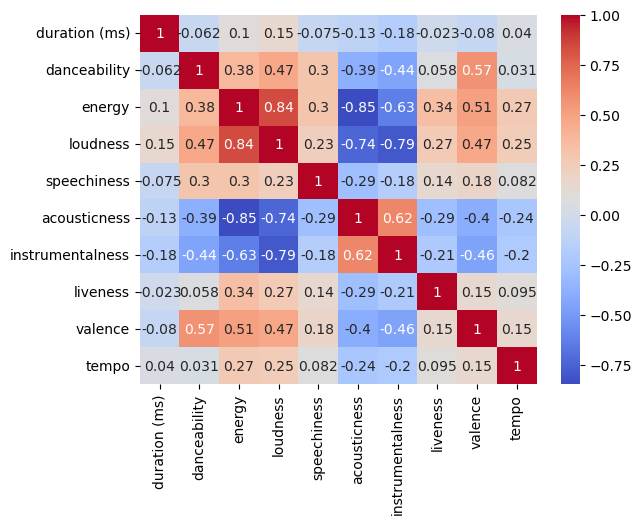

In [7]:
sns.heatmap(df.drop(columns='labels').corr(), annot=True, cmap='coolwarm')
plt.show()

In [8]:
plot_data = MultiplePlotMaker()

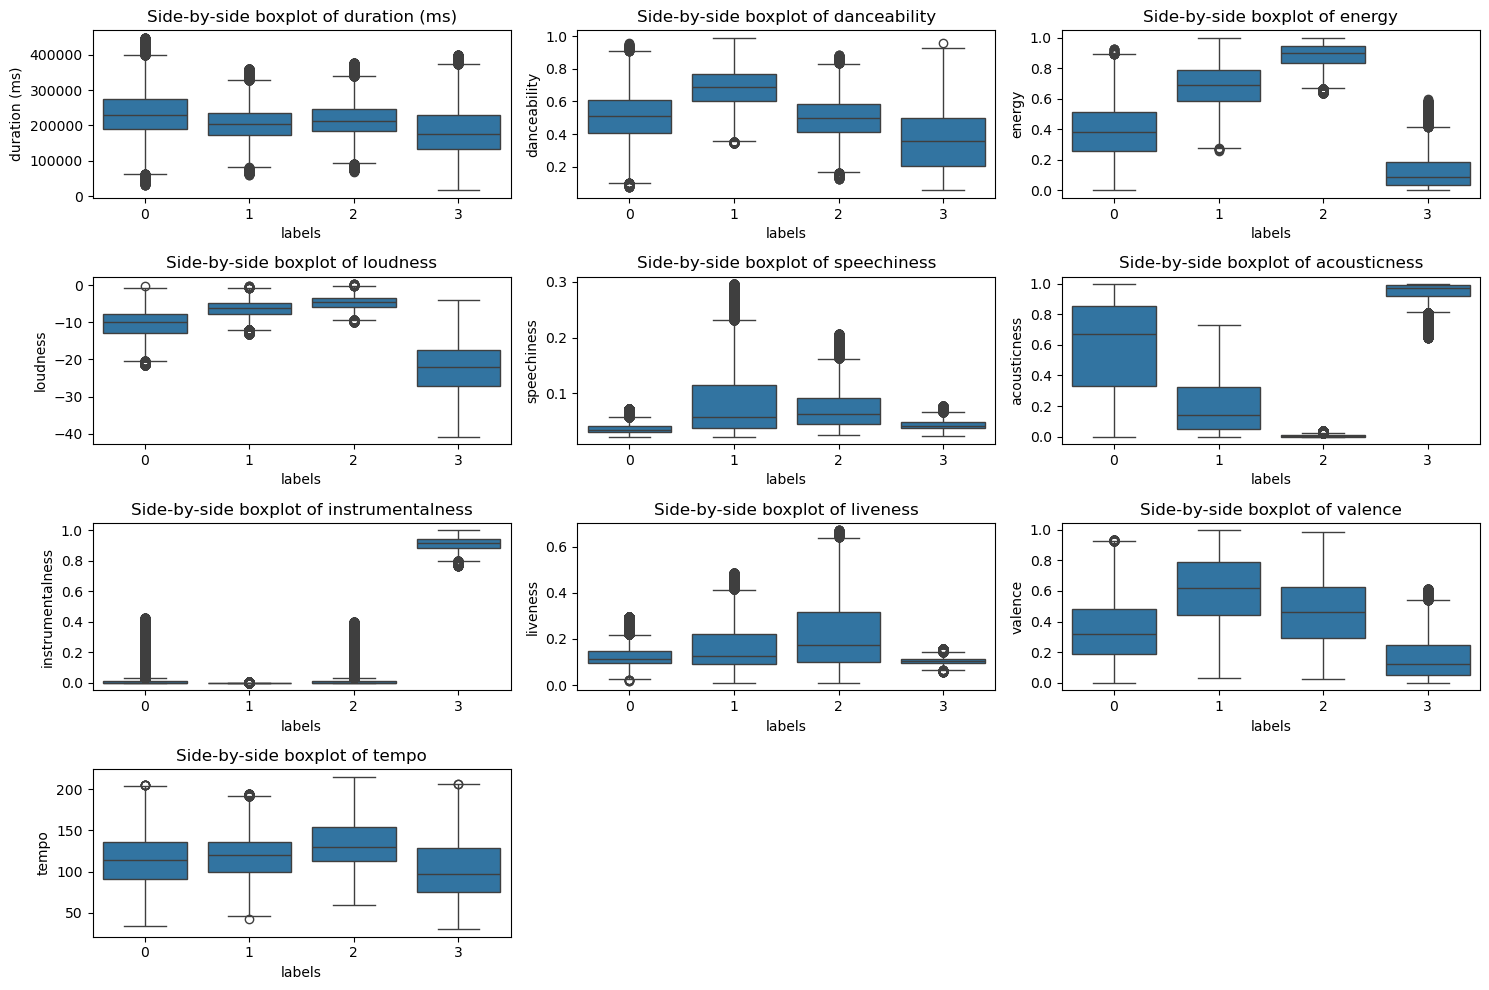

In [9]:
plot_data.plot_multiple_side_by_side_boxplots(df)

In [10]:
# Perform Anova and Mutual Information tests and also consider the feature importance that we obtain in random forest.
analysis_tools = StatAnalysisTools()

In [11]:
mi_scores = analysis_tools.mutual_info(df, target_col='labels')

acousticness        0.693016
energy              0.666538
instrumentalness    0.542511
loudness            0.536104
danceability        0.269929
valence             0.247883
speechiness         0.246526
liveness            0.158561
tempo               0.143553
duration (ms)       0.094182
dtype: float64


### Feature Importance

#### Strong Association

- energy
- danceability
- loudness
- acousticness
- instrumentalness
- valence

#### Medium Association
- speachness
- tempo

#### Weak Association
- duration ?
- liveness ?

### Machine Learning

labels
1    58517
0    42787
2    22935
3    21827
Name: count, dtype: int64


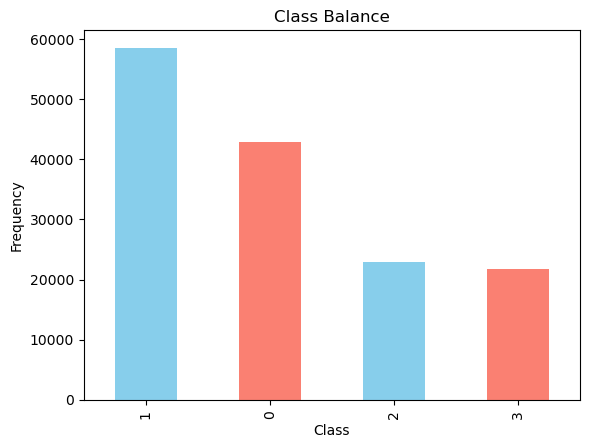

In [12]:
class_counts = df['labels'].value_counts()
print(class_counts)
# Plotting the bar graph
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])  # Adjust colors as needed
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Balance')
plt.show()

In [13]:
df.head()

duration (ms)  danceability  energy  loudness  speechiness  acousticness  \
0       242485.0         0.574   0.469    -8.209       0.0254         0.534   
1       176440.0         0.551   0.550    -5.339       0.0286         0.777   
2       183956.0         0.464   0.417    -9.345       0.0256         0.136   
3       244360.0         0.445   0.537    -8.532       0.0400         0.695   
4       184791.0         0.573   0.422    -7.621       0.0678         0.551   

   instrumentalness  liveness  valence    tempo  labels  
0          0.000092    0.1280    0.288  132.023       0  
1          0.000000    0.2020    0.342  101.190       0  
2          0.022000    0.0974    0.479   67.528       0  
3          0.000017    0.0944    0.131  122.769       0  
4          0.000013    0.1020    0.693  124.357       0

In [68]:
# X = df.drop(columns='labels')

X = df.drop(columns=['labels', 'duration (ms)', 'liveness', 'tempo'])

y = df.labels

print(X.head())
print(y.head())

   danceability  energy  loudness  speechiness  acousticness  \
0         0.574   0.469    -8.209       0.0254         0.534   
1         0.551   0.550    -5.339       0.0286         0.777   
2         0.464   0.417    -9.345       0.0256         0.136   
3         0.445   0.537    -8.532       0.0400         0.695   
4         0.573   0.422    -7.621       0.0678         0.551   

   instrumentalness  valence  
0          0.000092    0.288  
1          0.000000    0.342  
2          0.022000    0.479  
3          0.000017    0.131  
4          0.000013    0.693  
0    0
1    0
2    0
3    0
4    0
Name: labels, dtype: int64


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [70]:
scaler_type = RobustScaler()

In [71]:
estimator_pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', scaler_type),
        ('smote', SMOTE()),
        ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
    ]),
    'KNN': Pipeline([
        ('scaler', scaler_type),
        ('smote', SMOTE()),
        ('classifier', KNeighborsClassifier())
    ]),
    'Random Forest': Pipeline([
        ('smote', SMOTE()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
}

In [72]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Use 'weighted' to account for class imbalance
scorer = make_scorer(f1_score, average='weighted')  

for estimator_name, estimator_pipeline in estimator_pipelines.items():
    scores = cross_val_score(estimator_pipeline, X_train, y_train, scoring=scorer, cv=cv)
    print(f'{estimator_name} F1-score: {scores.mean():.3f} ± {scores.std():.3f}')

Logistic Regression F1-score: 0.933 ± 0.001
KNN F1-score: 0.920 ± 0.001
Random Forest F1-score: 0.962 ± 0.001


In [73]:
rf_pipeline = estimator_pipelines['Random Forest']

# Fit the pipeline to the training data
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 0.964
Precision: 0.965
Recall: 0.964
F1-Score: 0.964
ROC-AUC Score: 0.998
Confusion Matrix:
[[ 8255   239    64     0]
 [  308 11121   275     0]
 [   20   135  4432     0]
 [    0     0     0  4365]]


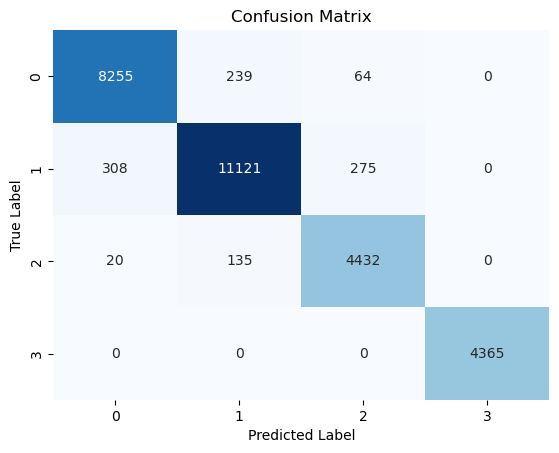

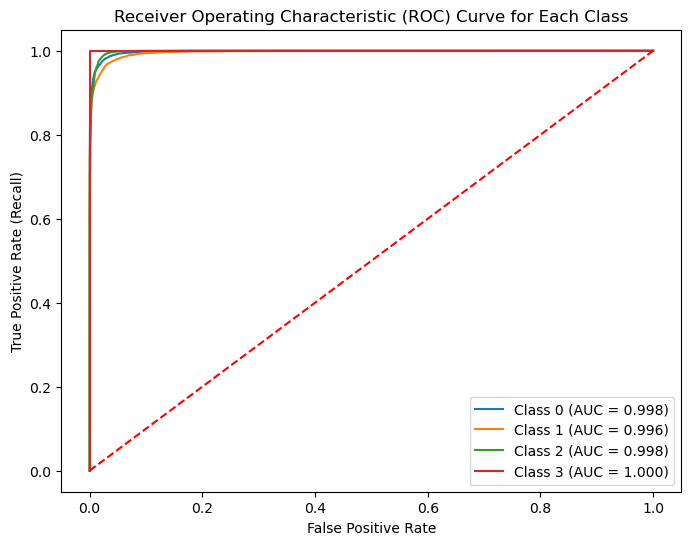

In [74]:
mode_evaluation = ModelEvaluation()
mode_evaluation.evaluate_classifier(X_test, y_test, trained_model=rf_pipeline.named_steps['classifier'])

In [75]:
# Extract the trained RandomForestClassifier from the pipeline
rf_model = rf_pipeline.named_steps['classifier']

# Get the feature importances
feature_importances = rf_model.feature_importances_

# Assuming you have a list of feature names
feature_names = X_train.columns  # or specify your list of feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


            Feature  Importance
5  instrumentalness    0.285493
4      acousticness    0.231194
1            energy    0.185273
2          loudness    0.111218
0      danceability    0.076117
3       speechiness    0.065083
6           valence    0.045622


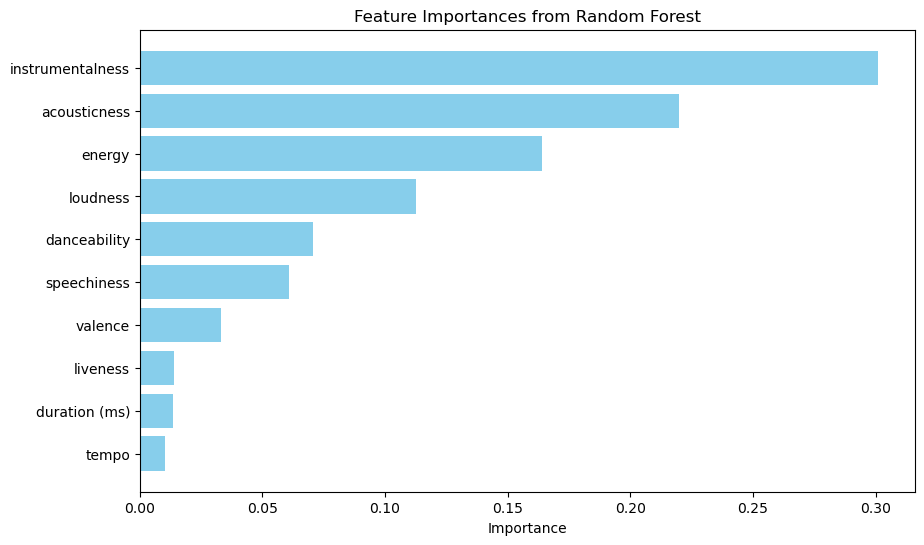

In [67]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()


In [76]:
df.columns

Index(['duration (ms)', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'labels'],
      dtype='object')

### Results:
Features: 'duration (ms)', 'danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence','tempo'.
- All features:

    Accuracy: 0.973
    Precision: 0.973
    Recall: 0.973
    F1-Score: 0.973
    ROC-AUC Score: 0.999


- Without duration, liveness, and tempo

    Accuracy: 0.964
    Precision: 0.965
    Recall: 0.964
    F1-Score: 0.964
    ROC-AUC Score: 0.998

In [77]:
df_new_songs = pd.read_csv('raw_data/BillboardHot100_2024.csv')
df_new_songs = df_new_songs.drop(columns=['Rank', 'Last', 'Featuring', 'Liveness', 'Peak', 'Weeks', 'Age', 'Key', 'Duration', 'Tempo'])
df_new_songs.head()

Title                  Artist    Released  Popularity  \
0  A Bar Song (Tipsy)               Shaboozey  2024-04-12          91   
1     I Had Some Help             Post Malone  2024-05-10          92   
2    Die With A Smile  Lady Gaga & Bruno Mars  2024-08-16          94   
3         Not Like Us          Kendrick Lamar  2024-05-04          95   
4  Birds Of A Feather           Billie Eilish  2024-05-17         100   

   Danceability  Energy  Loudness  Speechiness  Acousticness  \
0         0.722   0.709    -4.950       0.0273       0.06330   
1         0.638   0.855    -4.860       0.0264       0.00757   
2         0.521   0.592    -7.777       0.0304       0.30800   
3         0.898   0.472    -7.001       0.0776       0.01070   
4         0.747   0.507   -10.171       0.0358       0.20000   

   Instrumentalness  Valence  
0            0.0000    0.604  
1            0.0000    0.731  
2            0.0000    0.535  
3            0.0000    0.214  
4            0.0608    0.438

In [78]:
df_new_songs.columns = df_new_songs.columns.str.lower()
df_new_songs.columns

Index(['title', 'artist', 'released', 'popularity', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'valence'],
      dtype='object')

In [79]:
get_release_year = lambda x : x.split('-')[0]
df_new_songs['released'] = df_new_songs.released.apply(get_release_year)
df_new_songs.head()

title                  artist released  popularity  \
0  A Bar Song (Tipsy)               Shaboozey     2024          91   
1     I Had Some Help             Post Malone     2024          92   
2    Die With A Smile  Lady Gaga & Bruno Mars     2024          94   
3         Not Like Us          Kendrick Lamar     2024          95   
4  Birds Of A Feather           Billie Eilish     2024         100   

   danceability  energy  loudness  speechiness  acousticness  \
0         0.722   0.709    -4.950       0.0273       0.06330   
1         0.638   0.855    -4.860       0.0264       0.00757   
2         0.521   0.592    -7.777       0.0304       0.30800   
3         0.898   0.472    -7.001       0.0776       0.01070   
4         0.747   0.507   -10.171       0.0358       0.20000   

   instrumentalness  valence  
0            0.0000    0.604  
1            0.0000    0.731  
2            0.0000    0.535  
3            0.0000    0.214  
4            0.0608    0.438

In [80]:
df_new_songs.released.unique()

array(['2024', '2023', '2022', '2017'], dtype=object)

In [81]:
df_new_songs = df_new_songs[df_new_songs.released == '2024'].reset_index(drop=True)
df_new_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             81 non-null     object 
 1   artist            81 non-null     object 
 2   released          81 non-null     object 
 3   popularity        81 non-null     int64  
 4   danceability      81 non-null     float64
 5   energy            81 non-null     float64
 6   loudness          81 non-null     float64
 7   speechiness       81 non-null     float64
 8   acousticness      81 non-null     float64
 9   instrumentalness  81 non-null     float64
 10  valence           81 non-null     float64
dtypes: float64(7), int64(1), object(3)
memory usage: 7.1+ KB


In [82]:
df_new_songs.head(30)

title                                 artist  \
0                A Bar Song (Tipsy)                              Shaboozey   
1                   I Had Some Help                            Post Malone   
2                  Die With A Smile                 Lady Gaga & Bruno Mars   
3                       Not Like Us                         Kendrick Lamar   
4                Birds Of A Feather                          Billie Eilish   
5                  Good Luck, Babe!                          Chappell Roan   
6                          Espresso                      Sabrina Carpenter   
7               Million Dollar Baby                          Tommy Richman   
8              Please Please Please                      Sabrina Carpenter   
9                         Too Sweet                                 Hozier   
10                 Beautiful Things                           Benson Boone   
11                  Pour Me A Drink                            Post Malone   
12        Ain't No Love In Oklahoma                             Luke Combs   
13                       Pink Skies                             Zach Bryan   
14                     Guy For That                            Post Malone   
15                   Lies Lies Lies                          Morgan Wallen   
16                      Miles On It                Marshmello & Kane Brown   
17                       Wrong Ones                            Post Malone   
18                           Saturn                                    SZA   
19                           Losers                            Post Malone   
20                        Like That  Future, Metro Boomin & Kendrick Lamar   
21                          Kehlani                        Jordan Adetunji   
22                        Big Dawgs                    Hanumankind X Kalmi   
23                          Houdini                                 Eminem   
24                    I Am Not Okay                             Jelly Roll   
25                              Who                                  Jimin   
26                            Guess                             Charli xcx   
27                 California Sober                            Post Malone   
28                               28                             Zach Bryan   
29  I Can Do It With A Broken Heart                           Taylor Swift   

   released  popularity  danceability  energy  loudness  speechiness  \
0      2024          91         0.722   0.709    -4.950       0.0273   
1      2024          92         0.638   0.855    -4.860       0.0264   
2      2024          94         0.521   0.592    -7.777       0.0304   
3      2024          95         0.898   0.472    -7.001       0.0776   
4      2024         100         0.747   0.507   -10.171       0.0358   
5      2024          97         0.700   0.582    -5.960       0.0356   
6      2024          98         0.701   0.760    -5.478       0.0285   
7      2024          94         0.852   0.697    -5.520       0.0439   
8      2024          97         0.669   0.586    -6.073       0.0540   
9      2024          82         0.741   0.620    -5.505       0.0412   
10     2024          89         0.472   0.471    -5.692       0.0603   
11     2024          77         0.582   0.909    -3.834       0.0342   
12     2024          71         0.488   0.769    -5.835       0.0289   
13     2024          88         0.525   0.488    -6.909       0.0380   
14     2024          84         0.608   0.914    -4.116       0.0721   
15     2024          87         0.486   0.702    -5.758       0.0298   
16     2024          84         0.634   0.761    -4.752       0.0472   
17     2024          79         0.476   0.797    -3.867       0.0332   
18     2024          88         0.411   0.619    -6.834       0.0368   
19     2024          77         0.607   0.760    -4.024       0.0290   
20     2024          88         0.814   0.676    -4.670       0.2310   
21     2024          89    

In [83]:
X_sample = df_new_songs.drop(columns=['title', 'artist', 'released', 'popularity'])

In [84]:
new_labels = rf_pipeline.named_steps['classifier'].predict(X_sample)

In [85]:
df_new_songs['mood_labels'] = new_labels

In [86]:
df_new_songs[df_new_songs.mood_labels == 0].head()

title         artist released  popularity  \
4          Birds Of A Feather  Billie Eilish     2024         100   
10           Beautiful Things   Benson Boone     2024          89   
12  Ain't No Love In Oklahoma     Luke Combs     2024          71   
13                 Pink Skies     Zach Bryan     2024          88   
15             Lies Lies Lies  Morgan Wallen     2024          87   

    danceability  energy  loudness  speechiness  acousticness  \
4          0.747   0.507   -10.171       0.0358       0.20000   
10         0.472   0.471    -5.692       0.0603       0.15100   
12         0.488   0.769    -5.835       0.0289       0.00802   
13         0.525   0.488    -6.909       0.0380       0.19100   
15         0.486   0.702    -5.758       0.0298       0.23900   

    instrumentalness  valence  mood_labels  
4           0.060800    0.438            0  
10          0.000000    0.219            0  
12          0.008810    0.267            0  
13          0.000051    0.253            0  
15          0.000075    0.382            0

In [87]:
df_new_songs[df_new_songs.mood_labels == 1].head()

title                  artist released  popularity  \
0  A Bar Song (Tipsy)               Shaboozey     2024          91   
1     I Had Some Help             Post Malone     2024          92   
2    Die With A Smile  Lady Gaga & Bruno Mars     2024          94   
3         Not Like Us          Kendrick Lamar     2024          95   
5    Good Luck, Babe!           Chappell Roan     2024          97   

   danceability  energy  loudness  speechiness  acousticness  \
0         0.722   0.709    -4.950       0.0273       0.06330   
1         0.638   0.855    -4.860       0.0264       0.00757   
2         0.521   0.592    -7.777       0.0304       0.30800   
3         0.898   0.472    -7.001       0.0776       0.01070   
5         0.700   0.582    -5.960       0.0356       0.05020   

   instrumentalness  valence  mood_labels  
0               0.0    0.604            1  
1               0.0    0.731            1  
2               0.0    0.535            1  
3               0.0    0.214            1  
5               0.0    0.785            1

In [90]:
df_new_songs[df_new_songs.mood_labels == 2]

title         artist released  popularity  \
11              Pour Me A Drink    Post Malone     2024          77   
14                 Guy For That    Post Malone     2024          84   
17                   Wrong Ones    Post Malone     2024          79   
26                        Guess     Charli xcx     2024          92   
27             California Sober    Post Malone     2024          76   
34                 Finer Things    Post Malone     2024          75   
47                  Bulletproof     Nate Smith     2024          72   
49          Goes Without Saying    Post Malone     2024          74   
63             Hang Tight Honey  Lainey Wilson     2024          70   
68                  M-E-X-I-C-O    Post Malone     2024          56   
71  Love You, Miss You, Mean It     Luke Bryan     2024          68   
72              Right About You    Post Malone     2024          71   

    danceability  energy  loudness  speechiness  acousticness  \
11         0.582   0.909    -3.834       0.0342       0.00191   
14         0.608   0.914    -4.116       0.0721       0.00545   
17         0.476   0.797    -3.867       0.0332       0.00552   
26         0.776   0.667    -6.622       0.0983       0.01460   
27         0.455   0.968    -3.672       0.0391       0.00396   
34         0.629   0.937    -3.477       0.0378       0.00519   
47         0.444   0.727    -5.177       0.0394       0.03610   
49         0.472   0.777    -5.000       0.0302       0.00119   
63         0.494   0.956    -4.670       0.0729       0.02660   
68         0.609   0.967    -3.440       0.0517       0.01050   
71         0.450   0.812    -4.338       0.0419       0.01850   
72         0.442   0.858    -5.316       0.0337       0.00606   

    instrumentalness  valence  mood_labels  
11          0.000000    0.868            2  
14          0.000000    0.511            2  
17          0.000000    0.601            2  
26          0.300000    0.618            2  
27          0.000021    0.686            2  
34          0.000000    0.649            2  
47          0.000000    0.519            2  
49          0.000000    0.484            2  
63          0.000036    0.772            2  
68          0.000000    0.605            2  
71          0.000003    0.591            2  
72          0.000000    0.724            2

In [89]:
df_new_songs[df_new_songs.mood_labels == 3].head()

title         artist released  popularity  danceability  energy  \
76  Chihiro  Billie Eilish     2024          91           0.7   0.425   

    loudness  speechiness  acousticness  instrumentalness  valence  \
76   -12.531       0.0529         0.144             0.879    0.521   

    mood_labels  
76            3